In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/300/'

os.chdir(current_path)

Mounted at /content/drive


### requirements

In [ ]:
!pip install mpl_finance

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from funcs_indicator import *
from funcs_for_trade import *
# import matplotlib.pyplot as plt

import mpl_finance as mf
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import pickle

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### load data

In [3]:
os.chdir(current_path)


interval = '30m'
interval = '1m'

date_path = './candlestick_concated/%s/2021-04-27/' % interval
date_path = './candlestick_concated/%s/2021-05-17/' % interval
# date_path = './candlestick_concated/%s/2021-06-14/' % interval
date_path = './candlestick_concated/%s/eth_set/' % interval
file_list = os.listdir(date_path)
print((file_list))

interval = '3m'
date_path2 = './candlestick_concated/%s/eth_set/' % interval
file_list2 = os.listdir(date_path2)
print((file_list2))


['2021-05-17 ETHUSDT.xlsx', '2021-04-17 ETHUSDT.xlsx', '2021-03-18 ETHUSDT.xlsx', '2021-02-16 ETHUSDT.xlsx', '2021-01-17 ETHUSDT.xlsx', '2020-12-18 ETHUSDT.xlsx', '2020-11-18 ETHUSDT.xlsx', '2020-10-19 ETHUSDT.xlsx', '2020-09-19 ETHUSDT.xlsx', '2020-08-20 ETHUSDT.xlsx', '2020-07-21 ETHUSDT.xlsx', '2020-06-21 ETHUSDT.xlsx', '2020-05-22 ETHUSDT.xlsx', '2020-04-22 ETHUSDT.xlsx']
['2021-05-17 ETHUSDT.xlsx', '2021-04-17 ETHUSDT.xlsx', '2021-03-18 ETHUSDT.xlsx', '2021-02-16 ETHUSDT.xlsx', '2021-01-17 ETHUSDT.xlsx', '2020-12-18 ETHUSDT.xlsx', '2020-11-18 ETHUSDT.xlsx', '2020-10-19 ETHUSDT.xlsx', '2020-09-19 ETHUSDT.xlsx', '2020-08-20 ETHUSDT.xlsx', '2020-07-21 ETHUSDT.xlsx', '2020-06-21 ETHUSDT.xlsx', '2020-05-22 ETHUSDT.xlsx', '2020-04-22 ETHUSDT.xlsx']


#### window settings

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

window_size = 30
input_size = 15
label_size = 15
shift_size = window_size

target = "pr"

start_stamp : 0


#### make datasets

In [ ]:
data_x, data_labels = [], []
data_x_labels = []

# close_x, label_close_x = [], []
# data_index = []

fee = 0.0006

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  # if 'neo'.upper() not in candis[i]:
    # continue
  
  # if 'btc'.upper() not in candis[i]:
  #   continue

  if 'eth'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))
    df = ohlcv

    df2 = pd.read_excel(date_path2 + key, index_col=0)
    # print("df2.head() :", df2.head())

    ha_df2 = heikinashi(df2)
    df2['minor_ST1_Up'], df2['minor_ST1_Down'], df2['minor_ST1_Trend'] = supertrend(df2, 10, 2)
    df2['minor_ST2_Up'], df2['minor_ST2_Down'], df2['minor_ST2_Trend'] = supertrend(ha_df2, 7, 2)
    df2['minor_ST3_Up'], df2['minor_ST3_Down'], df2['minor_ST3_Trend'] = supertrend(ha_df2, 7, 2.5)

    df = df.join(pd.DataFrame(index=df.index, data=to_lower_tf(df, df2, [i for i in range(-9, 0, 1)]),
                              columns=['minor_ST1_Up', 'minor_ST1_Down', 'minor_ST1_Trend'
                                  , 'minor_ST2_Up', 'minor_ST2_Down', 'minor_ST2_Trend'
                                  , 'minor_ST3_Up', 'minor_ST3_Down', 'minor_ST3_Trend']))
    
    print("df.tail() :", df.tail())

    # break

    # df['pr'] = df['close'].pct_change()

    #   진입 구간과 이탈 구간에서 발생하는 pr 만들기    #

    # df['pr'] = df['close'].shift(-(label_size - 1)) / df['close']

    #         post fee adjustment       #
    df['pr'] = df['close'].shift(-(label_size - 1)) / df['close'] - fee

    # print(df['close'].head(20))
    # print(df['close'].shift(-14).head(20))
    # break


    #       add new features      #

    # sar = lucid_sar(ohlcv)
    # ha_ohlc = heikinashi(ohlcv).iloc[:, :4]
    # ema1, ema2, ema3 = ema_ribbon(ohlcv)
    # senkou1, senkou2 = ichimoku(ohlcv)
    # cbo, ema_cbo = cct_bbo(ohlcv, 21, 13) 

    # _, _, bbw = bb_width(ohlcv, 20, 2) 

    #         htf 만들기        #

    df['fish60'] = fisher(ohlcv, 60)
    df['trix'] = trix_hist(ohlcv, 14, 1, 5) 
    # rsi_ = rsi(ohlcv)
    df['macd_hist'] = macd(ohlcv)

    # print(df.describe().transpose())
    # print(df.head())

    # print((np.isnan(df.values)))
    print("np.sum(np.isnan(df.values), axis=0) :", np.sum(np.isnan(df.values), axis=0))

    max_nan = np.max(np.sum(np.isnan(df.values), axis=0))
    # print(max_nan)

    df = df.iloc[max_nan:-max_nan]

    print("df.describe().transpose() :", df.describe().transpose())


    column_indices = {name: i for i, name in enumerate(df.columns)}
    num_features = df.shape[1]
    print("num_features :", num_features)
    print("column_indices :", column_indices)
    
    target_label_index = column_indices[target]

    from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
    min_max = MinMaxScaler()
    std_scale = StandardScaler()

    def min_max_scale(npy_x):

      return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))


    #       local scaling     #
    # shift_size = window_size
    # shift_size = 1

    for i in range(input_size, len(df), shift_size):
        
        # temp_data = df.values[i - input_size:i]
        # temp_labels = df.values[i:i + label_size]

        # scaled_data = min_max_scale(df.values[i - input_size:i + label_size])
        # scaled_data = min_max.fit_transform(df.values[i - input_size:i + label_size])
        # temp_data = scaled_data[:input_size]
        # temp_labels = scaled_data[input_size:]

        #       input columns      #
        # input_columns = [0, 1, 2, 3]
        input_columns = [0, 1, 2, 3, 5, 6, 8, 9, 11, 12]

        #     ohlc    #
        temp_data = min_max_scale(df.values[i - input_size:i, input_columns])
        
        prev_data = df.values[i - input_size:i, input_columns]
        label_data = df.values[i: i + label_size, input_columns]
        temp_x_labels = (label_data - np.min(prev_data)) / (np.max(prev_data) - np.min(prev_data))

        temp_labels = df.values[i, target_label_index]

        # temp_data = std_scale.fit_transform(df.values[i - input_size:i])
        # # temp_labels = std_scale.transform(df.values[i:i + label_size])
        # temp_labels = df.values[i + shift - input_size:i + shift]

        # print(df.index[i - input_size:i][-1])
        # print(df.index[i:i + label_size][0])
        # print()

        if np.isnan(np.sum(temp_data)):
          continue

        data_x.append(temp_data)
        data_x_labels.append(temp_x_labels)
        data_labels.append(temp_labels)
        # close_x.append(df.values[i - input_size:i, [3]])
        # label_close_x.append(df.values[i:i + label_size, [3]])


data_x = np.array(data_x).astype(np.float32)
data_x_labels = np.array(data_x_labels).astype(np.float32)
data_labels = np.array(data_labels).astype(np.float32)

# print(len(df) - total_window_size)
print("data_x.shape :", data_x.shape)
print("data_x_labels.shape :", data_x_labels.shape)
print("data_labels.shape :", data_labels.shape)

print("data_x.dtype :", data_x.dtype)
print("data_labels.dtype :", data_labels.dtype)

len(ohlcv) : 43200
df.tail() :                             open     high      low    close    volume  minor_ST1_Up  minor_ST1_Down  minor_ST1_Trend  minor_ST2_Up  minor_ST2_Down  minor_ST2_Trend  minor_ST3_Up  minor_ST3_Down  minor_ST3_Trend
2021-03-18 23:55:59.999  1791.84  1795.94  1791.75  1795.94  1130.324   1798.674464     1786.599098              1.0   1799.207456     1781.544698             -1.0   1801.139648     1778.212123             -1.0
2021-03-18 23:56:59.999  1795.94  1796.00  1793.84  1794.60  1247.814   1798.674464     1786.599098              1.0   1799.207456     1781.544698             -1.0   1801.139648     1778.212123             -1.0
2021-03-18 23:57:59.999  1794.51  1794.70  1792.32  1792.37   839.821   1798.674464     1786.599098              1.0   1799.207456     1781.544698             -1.0   1801.139648     1778.212123             -1.0
2021-03-18 23:58:59.999  1792.37  1794.20  1792.36  1793.94   410.584   1798.674464     1786.599098              1.0   1799.2

#### save dataset

In [ ]:
pair_name = key.split(".")[0].split(" ")[1]
x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))
x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))
label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))

np.save(x_save_path, data_x)
np.save(x_label_save_path, data_x_labels)
np.save(label_save_path, data_labels)


#### load dataset

In [5]:
key = "dates ETHUSDT.xlsx"
len_data_x = 20104

pair_name = key.split(".")[0].split(" ")[1]
x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)
x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)
label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)

data_x = np.load(x_save_path)
data_x_labels = np.load(x_label_save_path)
data_labels = np.load(label_save_path)

print("data_x.shape :", data_x.shape)
print("data_x_labels.shape :", data_x_labels.shape)
print("data_labels.shape :", data_labels.shape)

data_x.shape : (20104, 15, 10)
data_x_labels.shape : (20104, 15, 10)
data_labels.shape : (20104,)


### embedding extractor

#### resnet

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(weights='imagenet', include_top=False)
# model.summary()


94773248/94765736 [==============================] - 0s 0us/step


#### pretrained custom model

In [ ]:
pair_name = "ETHUSDT"
window_size = 30
input_size = 15
label_size = 15
last_index = 10000

model_name = 'inner_tick_cnn_lscalemm_%s_%s_%s_%s_copy.h5' % (pair_name, input_size, label_size, last_index)
ckpt_path = current_path + 'ckpt/'

model = tf.keras.models.load_model(ckpt_path + model_name)
model = tf.keras.models.Sequential(model.layers[:-1])

In [ ]:
# for layer in model.layers:
#   print(layer.name)

### testbed

#### find best pattern

In [7]:
#         1. data slicing      #
tvt_size = len(data_x)
# shift_size = int(tvt_size * 0.1)
# shift_i = 0


#   reshape to 3d   #
# data_x = data_x.reshape(-1, data_x.shape[1], data_x.shape[2], 1)
re_data_x = data_x.reshape(-1, data_x.shape[1], data_x.shape[2], 1) * np.ones(3, dtype=np.float32)[None, None, None, :]

re_data_x_labels = data_x_labels.reshape(-1, data_x_labels.shape[1], data_x_labels.shape[2], 1)

re_data_labels = data_labels.reshape(-1, 1)




train_x = re_data_x[:int(tvt_size * 0.6)]
val_x = re_data_x[int(tvt_size * 0.6):int(tvt_size * 0.8)]
test_x = re_data_x[int(tvt_size * 0.8):]

print("len(train_x) :", len(train_x))
print("len(val_x) :", len(val_x))
print("len(test_x) :", len(test_x))

train_x_labels = re_data_x_labels[:int(tvt_size * 0.6)]
val_x_labels = re_data_x_labels[int(tvt_size * 0.6):int(tvt_size * 0.8)]
test_x_labels = re_data_x_labels[int(tvt_size * 0.8):]

train_labels = re_data_labels[:int(tvt_size * 0.6)]
val_labels = re_data_labels[int(tvt_size * 0.6):int(tvt_size * 0.8)]
test_labels = re_data_labels[int(tvt_size * 0.8):]

pr_thresh = 1

train_y = np.where(train_labels > pr_thresh, 1, 0)
val_y = np.where(val_labels > pr_thresh, 1, 0)
test_y = np.where(test_labels > pr_thresh, 1, 0)

from tensorflow.keras import utils

train_y_ohe = utils.to_categorical(train_y, 2)
val_y_ohe = utils.to_categorical(val_y, 2)
test_y_ohe = utils.to_categorical(test_y, 2)

# train_y = train_labels[:, :, [target_label_index]]
# val_y = val_labels[:, :, [target_label_index]]
# test_y = test_labels[:, :, [target_label_index]]

# print("train_labels.shape :", train_labels.shape)
print("train_x.shape :", train_x.shape)
print("train_x_labels.shape :", train_x_labels.shape)
print("train_y.shape :", train_y.shape)
print()


#                         break for data spliting only                          #
# break

train_result = model.predict(train_x, verbose=1)
print(train_result.shape)


# lb_period = 500  # lb_period 내에서 threshold / k-sample 만큼 추출한 후 win_ratio 를 확인

def distance_logic(f1, f2):
  return np.linalg.norm(f1-f2)


threshold = 0.35
sample_size = 10
pr_thresh = 1.00
lvrg = 1
fee = 0.0006

show_detail = False
plotting = True
pr_plot = True
total_pr = []
max_wr = 0
wr_thresh = 0.6
best_pattern_dict = {}


for i in tqdm(range(len(train_result) - sample_size)):
  
  min_diff = np.inf
  sample_list = []
  nearest_pr = 1
  nearest_pr_list = []
  nearest_pr_list_index = []
  
  for j in range(i + 1, len(train_result)):

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(train_result[i], train_result[j])
    
    # if diff < min_diff:
    # if diff < min_diff and diff < threshold:
    if diff < threshold:

      min_diff = diff
      # print("min_diff updated to", min_diff)

    # if diff < threshold:
      nearest_pr = train_labels[j]

      #       마지막 인덱스의 diff 가 가장 작음   #
      nearest_pr_list.append(nearest_pr)
      nearest_pr_list_index.append(j)

  #         check wr        #
  # if len(sample_list) > 0:
  #   sample_list = np.array(sample_list)
  #   wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])
    
    # print("win_ratio : %.3f" % wr) 
    # print("sample cnt : %s" % len(sample_list))

  # if nearest_pr > 1:

  if len(nearest_pr_list) >= sample_size:
    
    np_nearest_pr_list = np.array(nearest_pr_list)
    temp_acc_pr = np.cumprod(np_nearest_pr_list)[-1]
    temp_wr = len(np_nearest_pr_list[np_nearest_pr_list > 1]) / len(np_nearest_pr_list)

    if temp_acc_pr > 1:
    # if temp_wr > wr_thresh:
      best_pattern_index = i
      max_wr = temp_wr
      best_pattern_index_pair = nearest_pr_list_index

      best_pattern_dict[i] = [temp_acc_pr, temp_wr, nearest_pr_list_index]

      
      # print()
      # print("min_diff :", min_diff)
      print("len(nearest_pr_list) :", len(nearest_pr_list))
      print("temp_wr :", temp_wr)
      print()

    if show_detail:
    #   print("win_ratio : %.3f" % wr) 
    #   print("sample cnt : %s" % len(sample_list))
      print("train_labels[i] :", train_labels[i])

    # total_pr.append(train_labels[i]) 
    
  # print("last min_diff", min_diff)
  # if len(total_pr) > 0 and show_detail:
  #   print("-------------------------------")
  #   print("acc pr : ", np.cumprod(total_pr)[-1])

# if len(total_pr) > 0 and pr_plot:
  
#   np_total_pr = (np.array(total_pr) - 1 - fee) * lvrg + 1
#   total_wr = len(np_total_pr[np_total_pr > 1]) / len(np_total_pr)
#   plt.plot(np.cumprod(np_total_pr))
#   plt.title("thr : %.2f\nwr : %.3f\nacc_pr : %.3f" % (threshold, total_wr, np.cumprod(np_total_pr)[-1]))
#   plt.show()



len(train_x) : 12062
len(val_x) : 4021
len(test_x) : 4021
train_x.shape : (12062, 15, 10, 3)
train_x_labels.shape : (12062, 15, 10, 1)
train_y.shape : (12062, 1)

377/377 [==============================] - 18s 9ms/step
(12062, 1, 1, 2048)


len(nearest_pr_list) : 14
temp_wr : 0.7142857142857143

len(nearest_pr_list) : 87
temp_wr : 0.4482758620689655

len(nearest_pr_list) : 38
temp_wr : 0.4473684210526316

len(nearest_pr_list) : 314
temp_wr : 0.5095541401273885

len(nearest_pr_list) : 57
temp_wr : 0.49122807017543857

len(nearest_pr_list) : 50
temp_wr : 0.4

len(nearest_pr_list) : 46
temp_wr : 0.4782608695652174

len(nearest_pr_list) : 23
temp_wr : 0.43478260869565216

len(nearest_pr_list) : 29
temp_wr : 0.6551724137931034

len(nearest_pr_list) : 18
temp_wr : 0.4444444444444444

len(nearest_pr_list) : 62
temp_wr : 0.5483870967741935

len(nearest_pr_list) : 167
temp_wr : 0.5269461077844312

len(nearest_pr_list) : 212
temp_wr : 0.49528301886792453

len(nearest_pr_list) : 158
temp_wr : 0.5189873417721519

len(nearest_pr_list) : 339
temp_wr : 0.48672566371681414

len(nearest_pr_list) : 29
temp_wr : 0.6206896551724138

len(nearest_pr_list) : 141
temp_wr : 0.48936170212765956

len(nearest_pr_list) : 31
temp_wr : 0.48387096774193

#### save dict

In [8]:
import pickle

dict_path = current_path + "pickles/" + 'best_patterns_postfee_rank_%s_%s_%s_%s_%s.pickle' % (input_size, label_size, shift_size, pair_name, len_data_x)

with open(dict_path,'wb') as f:
    pickle.dump(best_pattern_dict, f)

#### check best patterns

##### sort by acc_pr

In [32]:
for b_index in best_pattern_dict:
  print(best_pattern_dict[b_index])
  break

sorted_best_pattern_dict = sorted(best_pattern_dict.items(), key=(lambda x: x[1]), reverse=True)

# print(type(sorted_best_pattern_dict))

# top_best_pattern_dict = sorted_best_pattern_dict[:10]
top_best_pattern_dict = sorted_best_pattern_dict[:]

for b_index, value in top_best_pattern_dict:
  # print(sorted_best_pattern_dict[b_index])
  print(b_index, value)
  break

[1.0177195, 0.7142857142857143, [30, 186, 455, 783, 1116, 1859, 3582, 5342, 6613, 8468, 8854, 11240, 11315, 11610]]
11583 [1.1131693, 0.6976744186046512, [11609, 11627, 11644, 11647, 11660, 11669, 11673, 11683, 11685, 11694, 11701, 11703, 11713, 11724, 11735, 11739, 11756, 11762, 11797, 11802, 11808, 11819, 11823, 11855, 11861, 11862, 11868, 11889, 11894, 11896, 11915, 11921, 11933, 11948, 11949, 11961, 11966, 11967, 12016, 12017, 12021, 12057, 12059]]


In [ ]:
for t_i, (b_index, value) in enumerate(top_best_pattern_dict):

  fig = plt.figure(figsize=(10, 4))
  # ax = fig.add_subplot(211)
  ax = fig.add_subplot(111)

  i = b_index
  print("value :", value)
  j = value[-1][0]

  print("b_index :", b_index)
  best_pattern = train_result[b_index]

  #       concat with x_labels      #
  ind_temp_ohlc = np.vstack((train_x[i, :, :, 0], train_x_labels[i, :, :, 0]))
  # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

  index = np.arange(len(ind_temp_ohlc))
  candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
  mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

  plt.plot(ind_temp_ohlc[:, 4:])

  # ax2 = fig.add_subplot(212)
  ind_temp_ohlc = np.vstack((train_x[j, :, :, 0], train_x_labels[j, :, :, 0]))

  print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

  index = np.arange(len(ind_temp_ohlc))
  candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
  mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

  plt.plot(ind_temp_ohlc[:, 4:])

  # ------------------- #
  plt.title("%s ~= %s" % (i, j))

  # plt.plot(ind_temp_ohlc)
  plt.axvline(input_size)

  plt.show()
  plt.close()


#### best patterns on validation

In [36]:
val_result = model.predict(val_x, verbose=1)
print(val_result.shape)


# lb_period = 500  # lb_period 내에서 threshold / k-sample 만큼 추출한 후 win_ratio 를 확인


threshold = 0.35
sample_size = 1
pr_thresh = 1.00
lvrg = 1

show_detail = False
plotting = True
pr_plot = True
wr_thresh = 0.0

for b_index, value in top_best_pattern_dict:
# for b_index in best_pattern_dict:

  total_pr = []
  max_wr = 0

  min_diff = np.inf
  sample_list = []
  nearest_pr = 1
  nearest_pr_list = []
  nearest_pr_list_index = []

  best_pattern = train_result[b_index]

  for new_i in (range(len(val_result))):
    

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(val_result[new_i], best_pattern)

    # print("diff :", diff)
    
    # if diff < min_diff:
    # if diff < min_diff and diff < threshold:
    if diff < threshold:

      min_diff = diff
      # print("min_diff updated to", min_diff)

    # if diff < threshold:
      nearest_pr = val_labels[new_i]

      #       마지막 인덱스의 diff 가 가장 작음   #
      nearest_pr_list.append(nearest_pr)

    #         check wr        #
    # if len(sample_list) > 0:
    #   sample_list = np.array(sample_list)
    #   wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])
      
      # print("win_ratio : %.3f" % wr) 
      # print("sample cnt : %s" % len(sample_list))

    # if nearest_pr > 1:

  if len(nearest_pr_list) >= sample_size:
    

    if show_detail:
    #   print("win_ratio : %.3f" % wr) 
    #   print("sample cnt : %s" % len(sample_list))
      print("val_labels[i] :", val_labels[i])

    
    np_total_pr = (np.array(nearest_pr_list) - 1) * lvrg + 1
    total_wr = len(np_total_pr[np_total_pr > 1]) / len(np_total_pr)

    # if total_wr > wr_thresh:
    if np.cumprod(np_total_pr)[-1] > 1:
      plt.plot(np.cumprod(np_total_pr))
      plt.title("b_index : %s\nthr : %.2f\nwr : %.3f\nacc_pr : %.3f" % (b_index, threshold, total_wr, np.cumprod(np_total_pr)[-1]))
      plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### best patterns on test_set

126/126 [==============================] - 1s 11ms/step
(4021, 1, 1, 2048)


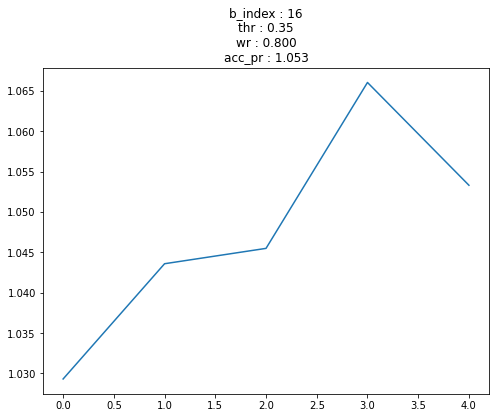

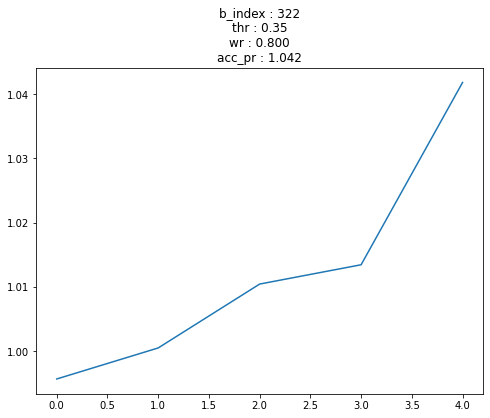

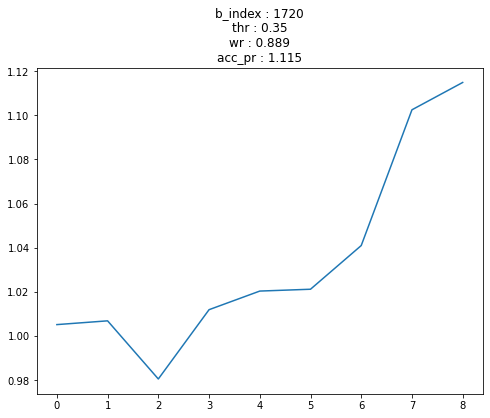

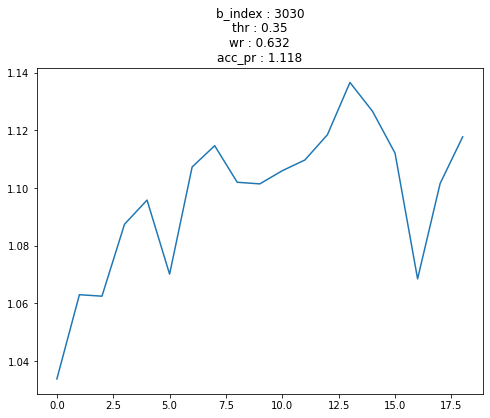

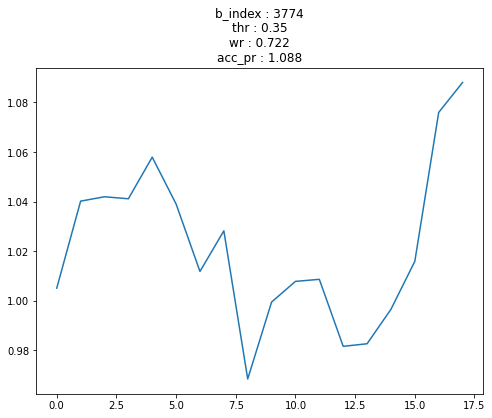

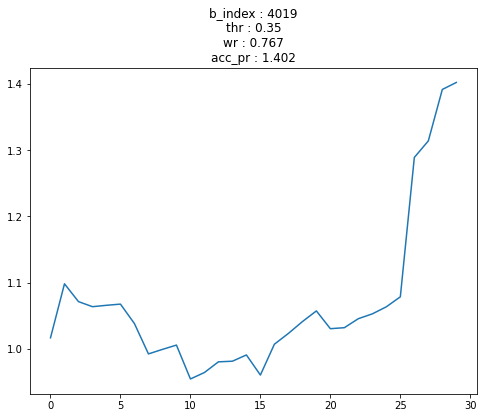

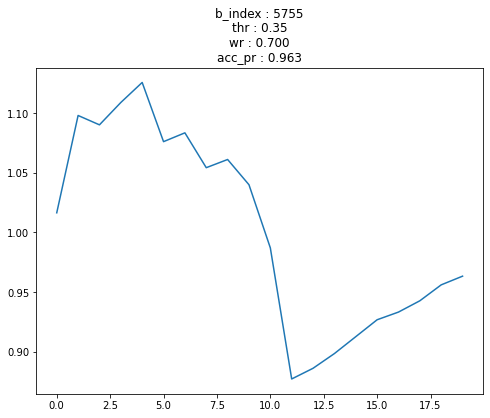

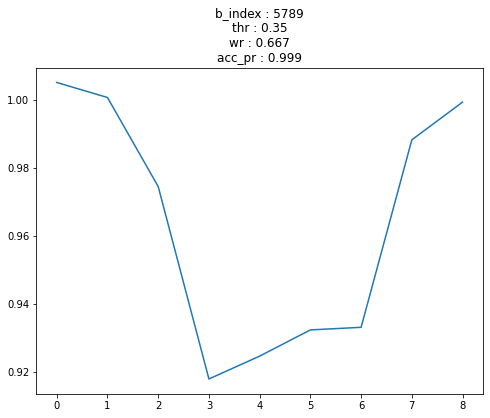

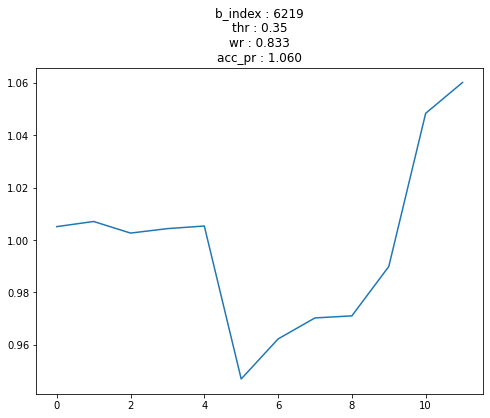

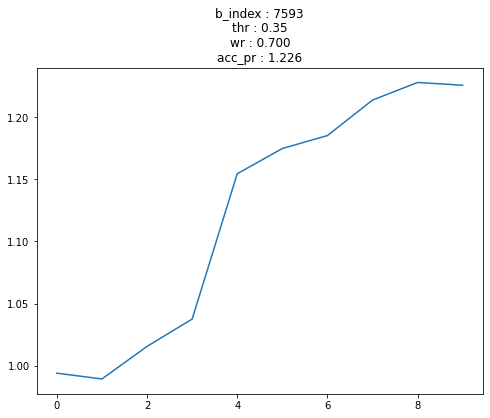

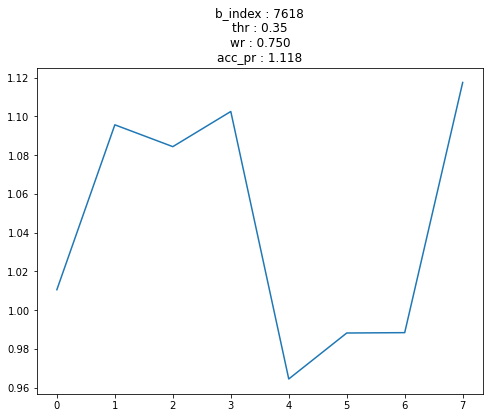

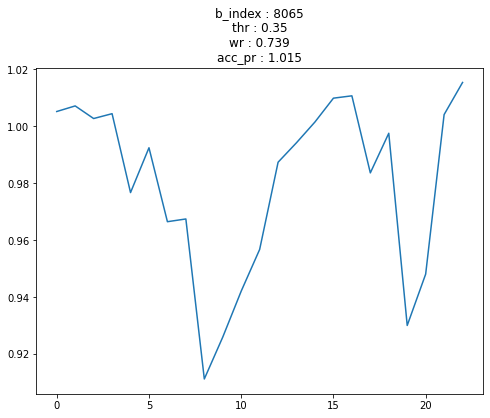

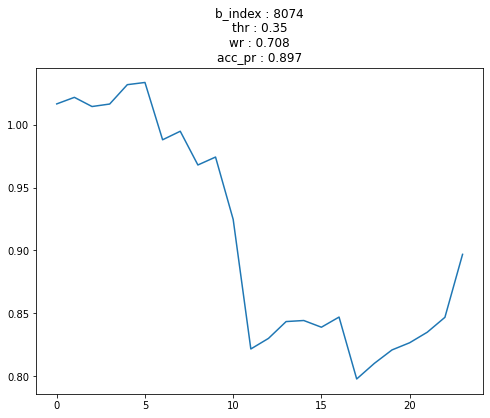

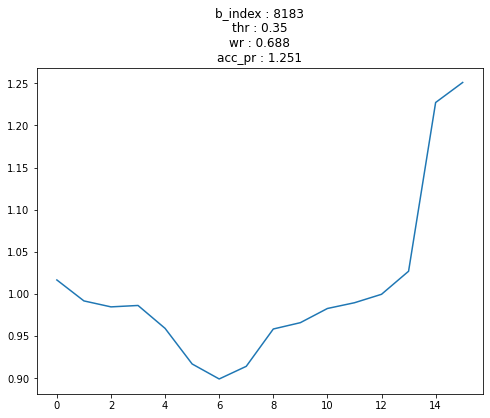

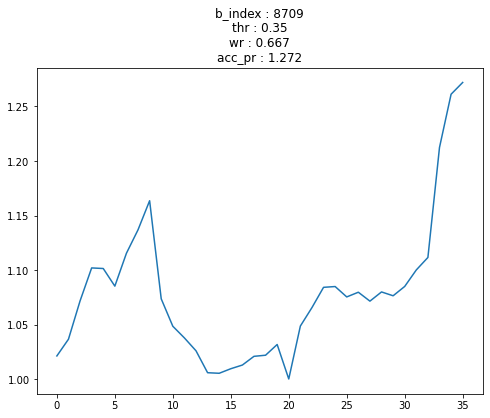

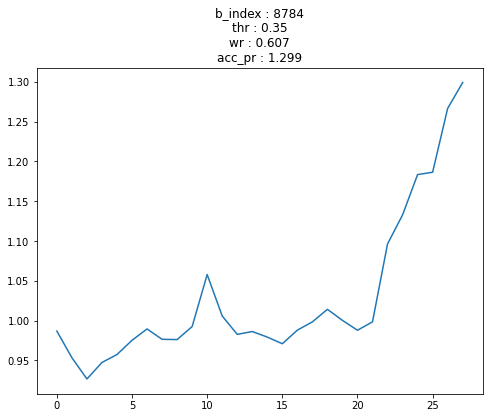

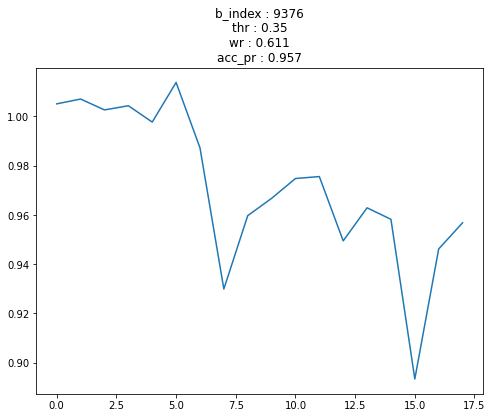

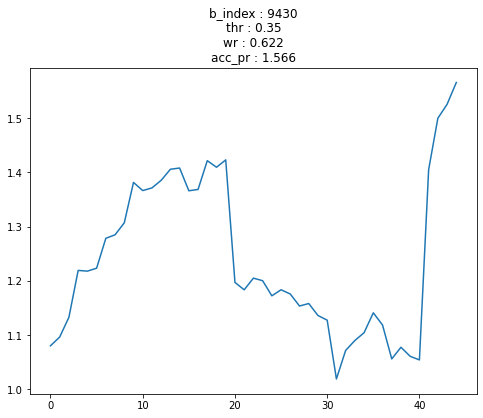

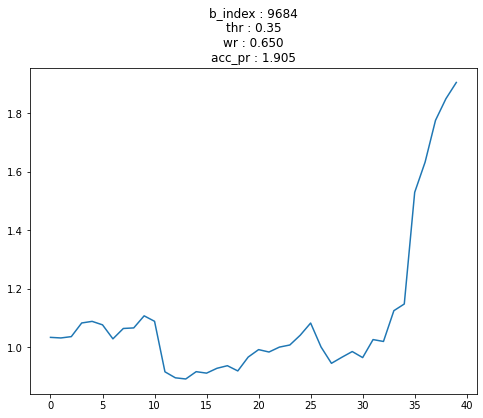

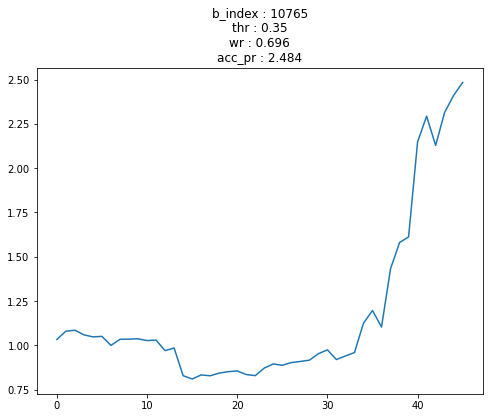

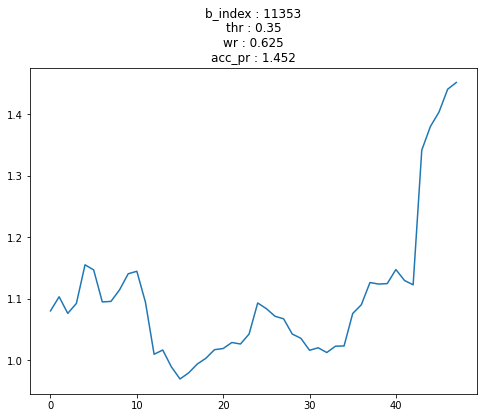

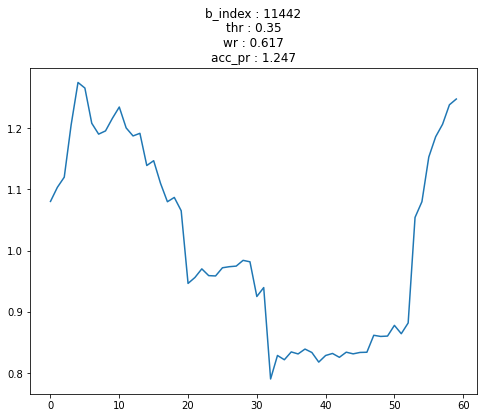

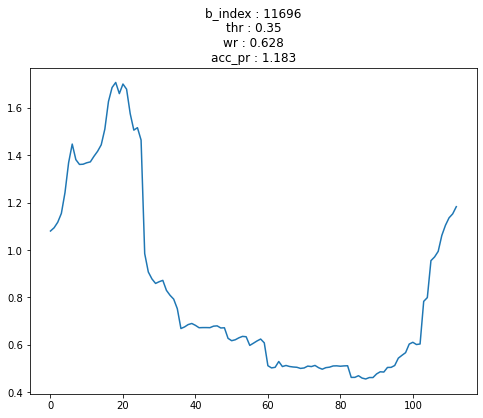

In [16]:
test_result = model.predict(test_x, verbose=1)
print(test_result.shape)


lb_period = 500  # lb_period 내에서 threshold / k-sample 만큼 추출한 후 win_ratio 를 확인



threshold = 0.35
sample_size = 1
pr_thresh = 1.00
lvrg = 5

show_detail = False
plotting = True
pr_plot = True
wr_thresh = 0.6

for b_index in best_pattern_dict:

  total_pr = []
  max_wr = 0

  min_diff = np.inf
  sample_list = []
  nearest_pr = 1
  nearest_pr_list = []
  nearest_pr_list_index = []

  best_pattern = train_result[b_index]

  for new_i in (range(len(test_result))):
    

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(test_result[new_i], best_pattern)
    
    # if diff < min_diff:
    # if diff < min_diff and diff < threshold:
    if diff < threshold:

      min_diff = diff
      # print("min_diff updated to", min_diff)

    # if diff < threshold:
      nearest_pr = test_labels[new_i]

      #       마지막 인덱스의 diff 가 가장 작음   #
      nearest_pr_list.append(nearest_pr)

    #         check wr        #
    # if len(sample_list) > 0:
    #   sample_list = np.array(sample_list)
    #   wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])
      
      # print("win_ratio : %.3f" % wr) 
      # print("sample cnt : %s" % len(sample_list))

    # if nearest_pr > 1:

  if len(nearest_pr_list) >= sample_size:
    

    if show_detail:
    #   print("win_ratio : %.3f" % wr) 
    #   print("sample cnt : %s" % len(sample_list))
      print("test_labels[i] :", test_labels[i])

    
    np_total_pr = (np.array(nearest_pr_list) - 1) * lvrg + 1
    total_wr = len(np_total_pr[np_total_pr > 1]) / len(np_total_pr)

    if total_wr > wr_thresh:
      plt.plot(np.cumprod(np_total_pr))
      plt.title("b_index : %s\nthr : %.2f\nwr : %.3f\nacc_pr : %.3f" % (b_index, threshold, total_wr, np.cumprod(np_total_pr)[-1]))
      plt.show()

### check similar pattern

#### feature extraction

In [ ]:
# avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# output = keras.layers.Flatten()(base_model.output)
# model = keras.models.Model(inputs=base_model.input, outputs=output)

# data_x_3c = data_x.reshape(-1, data_x.shape[1], data_x.shape[2], 1) * np.ones(3, dtype=np.float32)[None, None, None, :]

test_result = model.predict(test_x, verbose=1)
print(test_result.shape)

32/32 [==============================] - 16s 12ms/step
(1000, 1, 1, 2048)


#### get nearest feature

In [ ]:
import itertools
from tqdm.notebook import tqdm

def findDifference(f1, f2):
  return np.linalg.norm(f1-f2)

def findDifferences(feature_vectors, min_gap, lb_period=500):
  similar: dict = {}
  keys = [k for k,v in feature_vectors.items()]
  min : dict = {}
  # for k in keys:
  #     min[k] = np.inf

  possible_combinations=list(itertools.combinations(keys, 2))

  

  for i in range(lb_period, len(keys) - 1):

    min[i] = np.inf

    for j in range(i - lb_period, i):

      if abs(i - j) > min_gap:

        diff = findDifference(feature_vectors[i],feature_vectors[j])

        if diff < min[i]:
            min[i] = diff
            similar[i] = j
            # min[v] = diff
            # similar[v] = k

  # for i in tqdm(range(len(possible_combinations))):
  # # for i, (k,v) in range(len(possible_combinations)):
  #     k, v = possible_combinations[i]

  #     if abs(k - v) > min_gap:

  #       diff=findDifference(feature_vectors[k],feature_vectors[v])
  #       if diff < min[k]:
  #           min[k] = diff
  #           similar[k] = v
  #           min[v] = diff
  #           similar[v] = k

  return similar 



min_gap = 1

feature_vectors: dict = {}
for index in tqdm(range(len(test_result))):
    feature_vectors[index] = test_result[index]

results=findDifferences(feature_vectors, min_gap)

# for k,v in results.items():
#     # print(k +" is most similar to: "+ v)   
#     print("%s is most similar to: %s" % (k, v))   

    #print('Predicted:', decode_predictions(preds, top=3)[0])


#### check nearest one

##### right x_label version

In [ ]:
import mpl_finance as mf

for k, v in results.items():

  fig = plt.figure(figsize=(10, 4))
  ax = fig.add_subplot(121)
  # ax = fig.add_subplot(111)

  #       concat with x_labels      #
  ind_temp_data = np.vstack((test_x[k, :, :, 0], test_x_labels[k, :, :, 0]))
  ind_temp_ohlc = ind_temp_data[:, :4]
  ind_temp_st = ind_temp_data[:, 4:]
  # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

  index = np.arange(len(ind_temp_ohlc))
  candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
  mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

  plt.plot(ind_temp_st)
  plt.axvline(input_size)



  # ---------- label ---------- #
  ax2 = fig.add_subplot(122)
  ind_temp_data = np.vstack((test_x[v, :, :, 0], test_x_labels[v, :, :, 0]))
  ind_temp_ohlc = ind_temp_data[:, :4]
  ind_temp_st = ind_temp_data[:, 4:]

  print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

  index = np.arange(len(ind_temp_ohlc))
  candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
  # mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')
  mf.candlestick_ohlc(ax2, candle, width=0.5, colorup='m', colordown='c')

  plt.plot(ind_temp_st)


  plt.title("%s ~= %s" % (k, v))

  # plt.plot(ind_temp_ohlc)
  plt.axvline(input_size)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

##### wrong x_label version

In [ ]:
import mpl_finance as mf

for k, v in results.items():

  fig = plt.figure(figsize=(10, 4))
  ax = fig.add_subplot(121)
  # ax = fig.add_subplot(111)

  #       concat with x_labels      #
  ind_temp_ohlc = np.vstack((test_x[k, :, :4, 0], test_x_labels[k, :, :, 0]))
  # ind_temp_st = ind_temp_data[:, 4:]
  # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

  index = np.arange(len(ind_temp_ohlc))
  candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
  mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

  plt.plot(test_x[k, :, 4:, 0])



  # ---------- label ---------- #
  ax2 = fig.add_subplot(122)
  ind_temp_ohlc = np.vstack((test_x[v, :, :4, 0], test_x_labels[v, :, :, 0]))
  # ind_temp_ohlc = ind_temp_data[:, :4]
  # ind_temp_st = ind_temp_data[:, 4:]

  print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

  index = np.arange(len(ind_temp_ohlc))
  candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
  # mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')
  mf.candlestick_ohlc(ax2, candle, width=0.5, colorup='m', colordown='c')

  plt.plot(test_x[v, :, 4:, 0])


  plt.title("%s ~= %s" % (k, v))

  # plt.plot(ind_temp_ohlc)
  plt.axvline(input_size)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### k-means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

feature_list = []

for i in range(len(test_result)):

  feature_list.append(test_result[i].flatten())

feature_list = np.array(feature_list)
print(feature_list.shape)


K = range(2, 10)
s_dist = []
sil = []
for k in tqdm(K):
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(feature_list)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(feature_list, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()


### pr opt by similar pattern

#### winratio by nearest one

In [ ]:
from tqdm.notebook import tqdm
import mpl_finance as mf

lb_period = 500  # lb_period 내에서 threshold / k-sample 만큼 추출한 후 win_ratio 를 확인

def distance_logic(f1, f2):
  return np.linalg.norm(f1-f2)


threshold = 0.5

show_detail = False
plotting = False
pr_plot = False

total_ap = []
threshold_list = np.arange(0.3, 0.6, 0.01)
threshold_list = np.arange(0.6, 0.7, 0.01)

# threshold_list = [0.59]
# pr_plot = True

for threshold in tqdm(threshold_list):

  total_pr = []

  for i in (range(lb_period, len(test_result))):
    
    min_diff = np.inf
    sample_list = []
    nearest_pr = 1
    for j in range(i - lb_period, i):

      #       if feature distance under the threshold, append to the sample     #
      diff = distance_logic(test_result[i], test_result[j])
      
      # if diff < min_diff:
      if diff < min_diff and diff < threshold:
        min_diff = diff
        # print("min_diff updated to", min_diff)

      # if diff < threshold:
        nearest_pr = test_labels[j]

        if plotting:
          fig = plt.figure(figsize=(10, 4))
          # ax = fig.add_subplot(211)
          ax = fig.add_subplot(111)

          ind_temp_ohlc = x_test[i, :, :, 0]
          # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

          index = np.arange(len(ind_temp_ohlc))
          candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
          mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

          # ax2 = fig.add_subplot(212)
          ind_temp_ohlc = x_test[j, :, :, 0]
          print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

          index = np.arange(len(ind_temp_ohlc))
          candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
          mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

          plt.title("%s ~= %s" % (i, j))

          # plt.plot(ind_temp_ohlc)
          plt.show()
          plt.close()

    #         check wr        #
    # if len(sample_list) > 0:
    #   sample_list = np.array(sample_list)
    #   wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])
      
      # print("win_ratio : %.3f" % wr) 
      # print("sample cnt : %s" % len(sample_list))

    if nearest_pr > 1:

      if show_detail:
      #   print("win_ratio : %.3f" % wr) 
      #   print("sample cnt : %s" % len(sample_list))
        print("test_labels[i] :", test_labels[i])

      total_pr.append(test_labels[i]) 
      
    # print("last min_diff", min_diff)
    if len(total_pr) > 0 and show_detail:
      print("-------------------------------")
      print("acc pr : ", np.cumprod(total_pr)[-1])

  if len(total_pr) > 0 and pr_plot:
    np_total_pr = np.array(total_pr)
    total_wr = len(np_total_pr[np_total_pr > 1]) / len(np_total_pr)
    plt.plot(np.cumprod(np_total_pr))
    plt.title("thr : %.2f\nwr : %.3f\nacc_pr : %.3f" % (threshold, total_wr, np.cumprod(np_total_pr)[-1]))
    plt.show()

  total_ap.append(np.cumprod(total_pr)[-1])




#### find best threshold

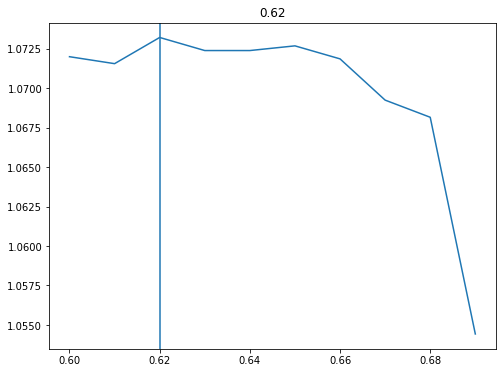

In [ ]:
np_total_ap = np.array(total_ap)
argmax = np.argmax(np_total_ap)
threshold_list = np.arange(0.3, 0.6, 0.01)
threshold_list = np.arange(0.6, 0.7, 0.01)


plt.plot(threshold_list, np_total_ap)
plt.axvline(threshold_list[argmax])
plt.title(threshold_list[argmax])
plt.show()

#### winratio by threshold

In [ ]:
from tqdm.notebook import tqdm
import mpl_finance as mf

lb_period = 500  # lb_period 내에서 threshold / k-sample 만큼 추출한 후 win_ratio 를 확인

def distance_logic(f1, f2):
  return np.linalg.norm(f1-f2)


threshold = 0.3

total_pr = []
show_detail = False
plotting = False

for i in tqdm(range(lb_period, len(test_result))):
  
  min_diff = np.inf
  sample_list = []
  for j in range(i - lb_period, i):

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(test_result[i], test_result[j])
    # if diff < min_diff:
    #   min_diff = diff
      # print("min_diff updated to", min_diff)

    if diff < threshold:
      sample_list.append(pr_test[j])

      if plotting:
        fig = plt.figure(figsize=(10, 4))
        # ax = fig.add_subplot(211)
        ax = fig.add_subplot(111)

        ind_temp_ohlc = x_test[i, :, :, 0]
        # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

        # ax2 = fig.add_subplot(212)
        ind_temp_ohlc = x_test[j, :, :, 0]
        print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

        plt.title("%s ~= %s" % (i, j))

        # plt.plot(ind_temp_ohlc)
        plt.show()
        plt.close()

  #         check wr        #
  if len(sample_list) > 0:
    sample_list = np.array(sample_list)
    wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])
    
    # print("win_ratio : %.3f" % wr) 
    # print("sample cnt : %s" % len(sample_list))

    if wr > .7:

      if show_detail:
        print("win_ratio : %.3f" % wr) 
        print("sample cnt : %s" % len(sample_list))
        print("pr_test[i] :", pr_test[i])

      total_pr.append(pr_test[i])
    
  # print("last min_diff", min_diff)
  if len(total_pr) > 0 and show_detail:
    print("-------------------------------")
    print("acc pr : ", np.cumprod(total_pr)[-1])





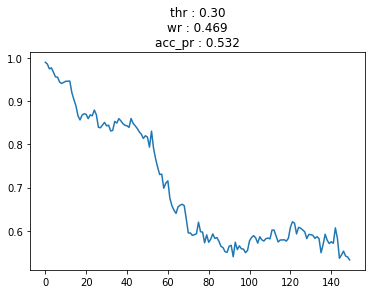

In [ ]:
total_pr = np.array(total_pr)
total_wr = len(total_pr[total_pr > 1]) / len(total_pr)
plt.plot(np.cumprod(total_pr))
plt.title("thr : %.2f\nwr : %.3f\nacc_pr : %.3f" % (threshold, wr, np.cumprod(total_pr)[-1]))
plt.show()

#### find best pattern & trade by it

In [ ]:
from tqdm.notebook import tqdm
import mpl_finance as mf

lb_period = 500  # lb_period 내에서 threshold / k-sample 만큼 추출한 후 win_ratio 를 확인

def distance_logic(f1, f2):
  return np.linalg.norm(f1-f2)


threshold = 0.3

total_pr = []
show_detail = True
plotting = False

most_acc_pr = 1
most_index_list = []

for i in tqdm(range(lb_period, len(test_result))):
  
  min_diff = np.inf
  sample_list = []
  for j in range(i - lb_period, i):

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(test_result[i], test_result[j])
    # if diff < min_diff:
    #   min_diff = diff
      # print("min_diff updated to", min_diff)

    if diff < threshold:
      sample_list.append(pr_test[j])

      if plotting:
        fig = plt.figure(figsize=(10, 4))
        # ax = fig.add_subplot(211)
        ax = fig.add_subplot(111)

        ind_temp_ohlc = x_test[i, :, :, 0]
        # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

        # ax2 = fig.add_subplot(212)
        ind_temp_ohlc = x_test[j, :, :, 0]
        print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

        plt.title("%s ~= %s" % (i, j))

        # plt.plot(ind_temp_ohlc)
        plt.show()
        plt.close()

  #         check wr        #
  if len(sample_list) > 0:
    sample_list = np.array(sample_list)
    wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])

    acc_pr = np.cumprod(sample_list)[-1]

    if acc_pr > 1:
    # if acc_pr > most_acc_pr:
      most_acc_pr = acc_pr
      most_index_list.append(i)
    
    # print("win_ratio : %.3f" % wr) 
    # print("sample cnt : %s" % len(sample_list))

    # if wr > .5:

    if show_detail:
      print("win_ratio : %.3f" % wr) 
      print("sample cnt : %s" % len(sample_list))
      print("acc_pr :", acc_pr)
      print("----------------------")

      # total_pr.append(pr_test[i])
    




Streaming output truncated to the last 5000 lines.
sample cnt : 33
acc_pr : 0.8729078
----------------------
win_ratio : 0.400
sample cnt : 25
acc_pr : 0.75526017
----------------------
win_ratio : 0.417
sample cnt : 12
acc_pr : 0.957374
----------------------
win_ratio : 0.250
sample cnt : 4
acc_pr : 0.93690974
----------------------
win_ratio : 0.250
sample cnt : 4
acc_pr : 0.931567
----------------------
win_ratio : 0.500
sample cnt : 6
acc_pr : 0.9935385
----------------------
win_ratio : 0.667
sample cnt : 3
acc_pr : 1.0112773
----------------------
win_ratio : 0.333
sample cnt : 3
acc_pr : 0.99940854
----------------------
win_ratio : 0.556
sample cnt : 9
acc_pr : 1.1174107
----------------------
win_ratio : 0.385
sample cnt : 13
acc_pr : 1.0130614
----------------------
win_ratio : 0.400
sample cnt : 5
acc_pr : 1.0736569
----------------------
win_ratio : 0.375
sample cnt : 8
acc_pr : 1.0485159
----------------------
win_ratio : 0.609
sample cnt : 23
acc_pr : 1.0484034
---------

#### check most list

In [ ]:
for i in most_index_list:

  fig = plt.figure(figsize=(5, 4))
  # ax = fig.add_subplot(211)
  ax = fig.add_subplot(111)

  ind_temp_ohlc = x_test[i, :, :, 0]
  # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

  index = np.arange(len(ind_temp_ohlc))
  candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
  mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

  plt.title("%s" % (i))

  # plt.plot(ind_temp_ohlc)
  plt.show()
  plt.close()

#### use most list

In [ ]:
val_result = model.predict(x_val, verbose=1)
print(val_result.shape)

110/110 [==============================] - 1s 12ms/step
(3499, 2, 1, 2048)


In [ ]:
threshold = 0.2
show_detail = True
val_most_list = []

for i in tqdm(most_index_list):
  
  min_diff = np.inf
  sample_list = []
  for j in range(len(val_result)):

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(test_result[i], val_result[j])
    # if diff < min_diff:
    #   min_diff = diff
      # print("min_diff updated to", min_diff)

    if diff < threshold:
      sample_list.append(pr_val[j])

      if plotting:
        fig = plt.figure(figsize=(10, 4))
        # ax = fig.add_subplot(211)
        ax = fig.add_subplot(111)

        ind_temp_ohlc = x_val[i, :, :, 0]
        # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

        # ax2 = fig.add_subplot(212)
        ind_temp_ohlc = x_val[j, :, :, 0]
        print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

        plt.title("%s ~= %s" % (i, j))

        # plt.plot(ind_temp_ohlc)
        plt.show()
        plt.close()

  #         check wr        #
  if len(sample_list) > 0:
    sample_list = np.array(sample_list)
    wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])

    acc_pr = np.cumprod(sample_list)[-1]

    if acc_pr > 1:
      # most_acc_pr = acc_pr
      val_most_list.append(j)
    
    # print("win_ratio : %.3f" % wr) 
    # print("sample cnt : %s" % len(sample_list))

    # if wr > .5:

      if show_detail:
        print("win_ratio : %.3f" % wr) 
        print("sample cnt : %s" % len(sample_list))
        print("acc_pr :", acc_pr)
        print("----------------------")

      # total_pr.append(pr_test[i])
    



In [ ]:
train_result = model.predict(x_train, verbose=1)
print(train_result.shape)

328/328 [==============================] - 4s 13ms/step
(10495, 2, 1, 2048)


In [ ]:
threshold = 0.2
show_detail = True
train_most_list = []

for i in tqdm(val_most_list):
  
  min_diff = np.inf
  sample_list = []
  for j in range(len(train_result)):

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(val_result[i], train_result[j])
    # if diff < min_diff:
    #   min_diff = diff
      # print("min_diff updated to", min_diff)

    if diff < threshold:
      sample_list.append(pr_train[j])

      if plotting:
        fig = plt.figure(figsize=(10, 4))
        # ax = fig.add_subplot(211)
        ax = fig.add_subplot(111)

        ind_temp_ohlc = x_train[i, :, :, 0]
        # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

        # ax2 = fig.add_subplot(212)
        ind_temp_ohlc = x_train[j, :, :, 0]
        print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

        plt.title("%s ~= %s" % (i, j))

        # plt.plot(ind_temp_ohlc)
        plt.show()
        plt.close()

  #         check wr        #
  if len(sample_list) > 0:
    sample_list = np.array(sample_list)
    wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])

    acc_pr = np.cumprod(sample_list)[-1]

    if acc_pr > 1:
      # most_acc_pr = acc_pr
      train_most_list.append(j)
    
    # print("win_ratio : %.3f" % wr) 
    # print("sample cnt : %s" % len(sample_list))

    # if wr > .5:

    if show_detail:
      print("win_ratio : %.3f" % wr) 
      print("sample cnt : %s" % len(sample_list))
      print("acc_pr :", acc_pr)
      print("----------------------")

      # total_pr.append(pr_test[i])
    

